Odpowiedź ma być skrypt pythona i odpalamy go z terminala za pomocą np. argparse

python classify.py test.csv

Na wejściu jest plik test.csv, tam mamy dopisać kolumnę nową z nazwą "RESULT" i nadpisać plik csv

* team: T – terrorists, CT – counter-terrorists;
* (detonation raw x, detonation raw y , detonation raw z ): grenade detonation raw coordinates;
* (throw from raw x, throw from raw y, throw from raw z ): raw coordinates of the player when the grenade is being thrown;
* throw tick : the exact tick (unit of game time, 128 ticks per second, counted from the beginning of the game), when the grenade is being thrown;
* detonation tick : the exact tick, when the grenade is being detonated;
* TYPE : type of the grenade (smoke, flashbang, molotov );
* map name: map on which the match was played (de inferno, de mirage);

In [16]:
import pandas as pd
import numpy as np

#visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


In [2]:
train = pd.read_csv('./data/train.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        543 non-null    int64  
 1   demo_id           543 non-null    int64  
 2   demo_round_id     543 non-null    int64  
 3   round_start_tick  543 non-null    int64  
 4   weapon_fire_id    543 non-null    int64  
 5   team              543 non-null    object 
 6   detonation_raw_x  543 non-null    float64
 7   detonation_raw_y  543 non-null    float64
 8   detonation_raw_z  543 non-null    float64
 9   throw_from_raw_x  543 non-null    float64
 10  throw_from_raw_y  543 non-null    float64
 11  throw_from_raw_z  543 non-null    float64
 12  throw_tick        543 non-null    int64  
 13  detonation_tick   543 non-null    float64
 14  TYPE              543 non-null    object 
 15  map_name          543 non-null    object 
 16  LABEL             543 non-null    bool   
dt

In [4]:
train.isna().sum()

Unnamed: 0          0
demo_id             0
demo_round_id       0
round_start_tick    0
weapon_fire_id      0
team                0
detonation_raw_x    0
detonation_raw_y    0
detonation_raw_z    0
throw_from_raw_x    0
throw_from_raw_y    0
throw_from_raw_z    0
throw_tick          0
detonation_tick     0
TYPE                0
map_name            0
LABEL               0
dtype: int64

Wiem, że mam do czynienia z danymi niezbalansowanymi  
* Muszę przejrzeć istotność danych cech  
* Muszę zrobić wykres z mapami csgo, napisanie funkcji, która przyjmuje na wejściu dany wiersz z train_data i wyrzuca obrazek gdzie jest oznaczone miejsce wyrzutu i opadniecia granatu
* Zamianienie informacji o tick na sekundy, dodanie moze nowej zmiennej, która będzie mówiła o tym ile leciał dany granat 
* wizualizacja, wizualizacja i jeszcze raz wizualizacja
* później spróbować zrobić PCA i zwizualizować dane, czy są liniowo, czy nieliniowo rozdzielne
* popatrzeć na modele, które mogę użyć
* Zaaplikować modele, następnie dodać skalowanie (zobaczyć, czy coś sie zmieni)
* Sprawdzić zespoły modelów 
* Dodać dostrajanie hiperparametrów 
* obczaić zapisywanie modelu (ang. serialized)
* obczaić jak odpalić to tak jak wymagają argparse

In [5]:
def scale_point_x(x,startX,endX,res_X=1024):
    sizeX=endX-startX
    if startX < 0:
        x += startX *(-1.0)
    else:
        x += startX
    x_out = float((x / abs(sizeX)) * res_X)
    return x_out

def scale_point_y(y,startY,endY,res_Y=1024):
    sizeY=endY-startY
    if startY < 0:
        y += startY *(-1.0)
    else:
        y += startY
    y_out = float((y / abs(sizeY)) * res_Y)
    return res_Y-y_out

In [6]:
mirage = train[(train['map_name'] == 'de_mirage')]

In [7]:

def add_attributes(df,startX,endX,startY,endY):
    df['detonation_x'] = df['detonation_raw_x'].apply(lambda x: scale_point_x(x,startX=startX, endX=endX))
    df['detonation_y'] = df['detonation_raw_y'].apply(lambda x: scale_point_y(x,startY=startY, endY=endY))
    df['throw_x'] = df['throw_from_raw_x'].apply(lambda x: scale_point_x(x,startX=startX, endX=endX))
    df['throw_y'] = df['throw_from_raw_y'].apply(lambda x: scale_point_y(x,startY=startY, endY=endY))
    return df

In [8]:
mirage = add_attributes(mirage,-3217,1912,-3401,1682)

In [9]:
def nades_on_map(df,map):
    map_name = map + '.png'
    im = plt.imread(map_name)
    plt.figure(figsize=(22,11))
    plt.subplot(1,2,1)
    t = plt.imshow(im)
    sns.scatterplot(x = df[df['LABEL'] == True]['detonation_x'], y = df[df['LABEL'] == True]['detonation_y'], hue = df[df['LABEL'] == True]['TYPE'], marker = "s", s = 50)
    ax = sns.scatterplot(x = df[df['LABEL'] == True]['throw_x'],y = df[df['LABEL'] == True]['throw_y'], hue = df[df['LABEL'] == True]['TYPE'], marker="^" , s = 50)
    handles, labels = ax.get_legend_handles_labels()
    detonation_patch = mlines.Line2D([], [], color = 'grey', marker='s', linestyle='None')
    throw_patch = mlines.Line2D([], [], color = 'grey', marker='^', linestyle='None')
    handles.extend([detonation_patch,throw_patch])
    labels.extend(['Detonation','Throw'])
    plt.legend(handles[3:], labels[3:])
    plt.title('Correct throw')


    plt.subplot(1,2,2)
    t = plt.imshow(im)
    sns.scatterplot(x = df[df['LABEL'] == False]['detonation_x'], y = df[df['LABEL'] == False]['detonation_y'], hue = df[df['LABEL'] == False]['TYPE'], marker = "s", s = 50)
    ax = sns.scatterplot(x = df[df['LABEL'] == False]['throw_x'],y = df[df['LABEL'] == False]['throw_y'], hue = df[df['LABEL'] == False]['TYPE'], marker="^" , s = 50)
    handles, labels = ax.get_legend_handles_labels()
    detonation_patch = mlines.Line2D([], [], color = 'grey', marker='s', linestyle='None')
    throw_patch = mlines.Line2D([], [], color = 'grey', marker='^', linestyle='None')
    handles.extend([detonation_patch,throw_patch])
    labels.extend(['Detonation','Throw'])
    plt.legend(handles[3:], labels[3:])
    plt.title('Incorrect throw')
    plt.show()


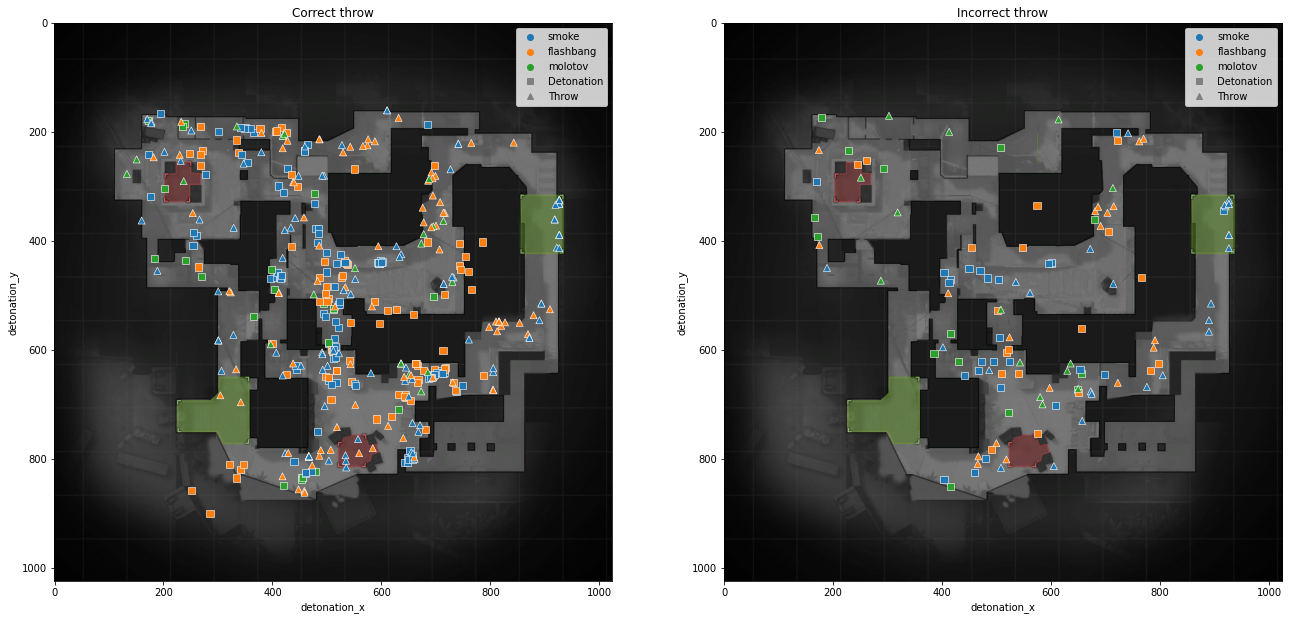

<Figure size 432x288 with 0 Axes>

In [17]:
nades_on_map(mirage,'de_mirage')
plt.savefig('./plots/granades_on_mirage.png')

In [18]:
inferno = train[(train['map_name'] == 'de_inferno')]

In [19]:
inferno = add_attributes(inferno,-1960,2797,-1062,3800)

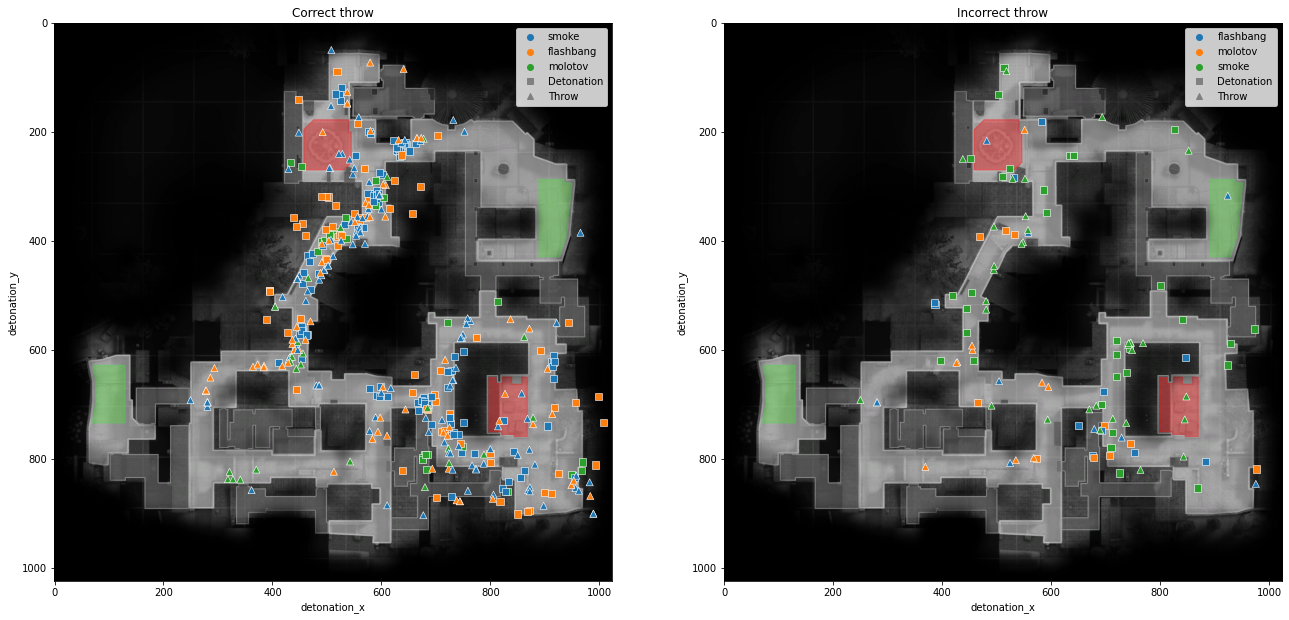

<Figure size 432x288 with 0 Axes>

In [20]:
nades_on_map(inferno,'de_inferno')
plt.savefig('./plots/granades_on_inferno.png')

In [33]:
#funtion to show one nade throwed
def draw_nade(row):
    map = row['map_name']
    label = row['LABEL']
    nade_type = row['TYPE'] 
    
    if map == 'de_inferno':
        map_name = map + '.png'
        startX,endX,startY,endY = -1960,2797,-1062,3800

    elif map == 'de_mirage':
        map_name = map + '.png'
        startX,endX,startY,endY = -3217,1912,-3401,1682

    else :
        print('Map incorrect')
    
    detonation_x = scale_point_x(row['detonation_raw_x'],startX = startX, endX = endX)
    detonation_y = scale_point_y(row['detonation_raw_y'],startY=startY, endY=endY)
    throw_x = scale_point_x(row['throw_from_raw_x'],startX=startX, endX=endX)
    throw_y = scale_point_y(row['throw_from_raw_y'],startY=startY, endY=endY)

    plt.figure(figsize=(11,11))
    im = plt.imread(map_name)
    t = plt.imshow(im)
    sns.scatterplot(x = [detonation_x], y = [detonation_y], color = 'blue', marker = "s", s = 50)
    ax = sns.scatterplot(x = [throw_x],y = [throw_y], color = 'orange', marker="^" , s = 50)
    detonation_patch = mlines.Line2D([], [], color = 'blue', marker='s', linestyle='None')
    throw_patch = mlines.Line2D([], [], color = 'orange', marker='^', linestyle='None')
    handles = [detonation_patch,throw_patch]
    labels = ['Detonation','Throw']
    ax.text(50, 100, 'Map:{},\nGranade:{},\nThrown correctly:{}'.format(map,nade_type,label),
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
    plt.legend(handles, labels)
    plt.show()


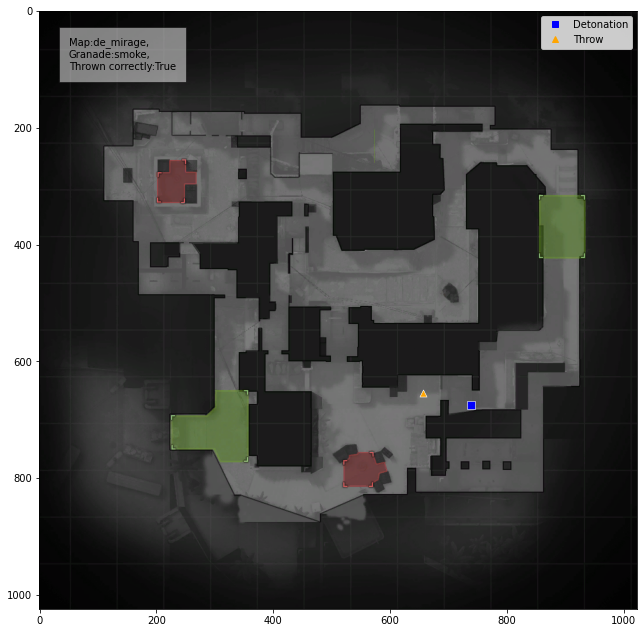

In [35]:
draw_nade(train.iloc[2])